In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir():  # make sure it exists
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

In [2]:
import options_wizard as ow
import pandas as pd

tick = 'TEVA'
universe = ow.Universe([tick])

data_manager = ow.DataManager(universe, load_lazy=True)

len(data_manager.universe.ticks)

C:\Users\cameronA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\exchange_calendars\exchange_calendar.py:2346: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


1

In [3]:
ow.Transformer(data_manager)('set_index', index_cols=['strike', 'trade_date', 'expiry_date', 'call_put'], dedupe=True)
ow.Transformer(data_manager)('get_underlying')
ow.Transformer(data_manager)('flag_chain_gaps', drop_on_gap = True)
ow.Transformer(data_manager)('scale_by_splits', upper_date = pd.Timestamp('2020-01-01'))
ow.Transformer(data_manager)('to_datetime', columns=['trade_date', 'expiry_date'])
ow.Transformer(data_manager)('flag_stale_options', volume_threshold=0)
ow.Transformer(data_manager)('drop_contract', drop = 'c')
ow.Transformer(data_manager)('pull_earnings_dates')
ow.Transformer(data_manager)('filter_ttms', min_ttm=3)
ow.Transformer(data_manager)('compute_rv', period=30)
ow.Transformer(data_manager)('train_test_split', test_size=0.45, drop_out_of_sample=True)
ow.Transformer(data_manager)('implied_volatility')
ow.Transformer(data_manager)('mid_price')


In [4]:
ow.Strategy(data_manager)('new_ratio_spread', lower_ttm=90, upper_ttm=150, delta_atm=0.35, delta_otm=0.15, otm_ratio=2, hold_period=30, call_put='p')
ow.Backtest(data_manager)('multi_day_entry', hold_period=30, entry_cost_size='short', initial_capital=1_000_000.0, capital_per_trade=0.025*12/(256), all_returns=True)
ow.Backtest(data_manager)("multi_stock", initial_capital=1_000_000, capital_per_day=0.025*12/(256), allocation_basis="short")
data_manager.execute_pipeline(retain_data=True, save_data=False, n_workers=4)

Deferring method multi_stock for all stocksRunning post-processing method multi_stock for ticks ['TEVA']


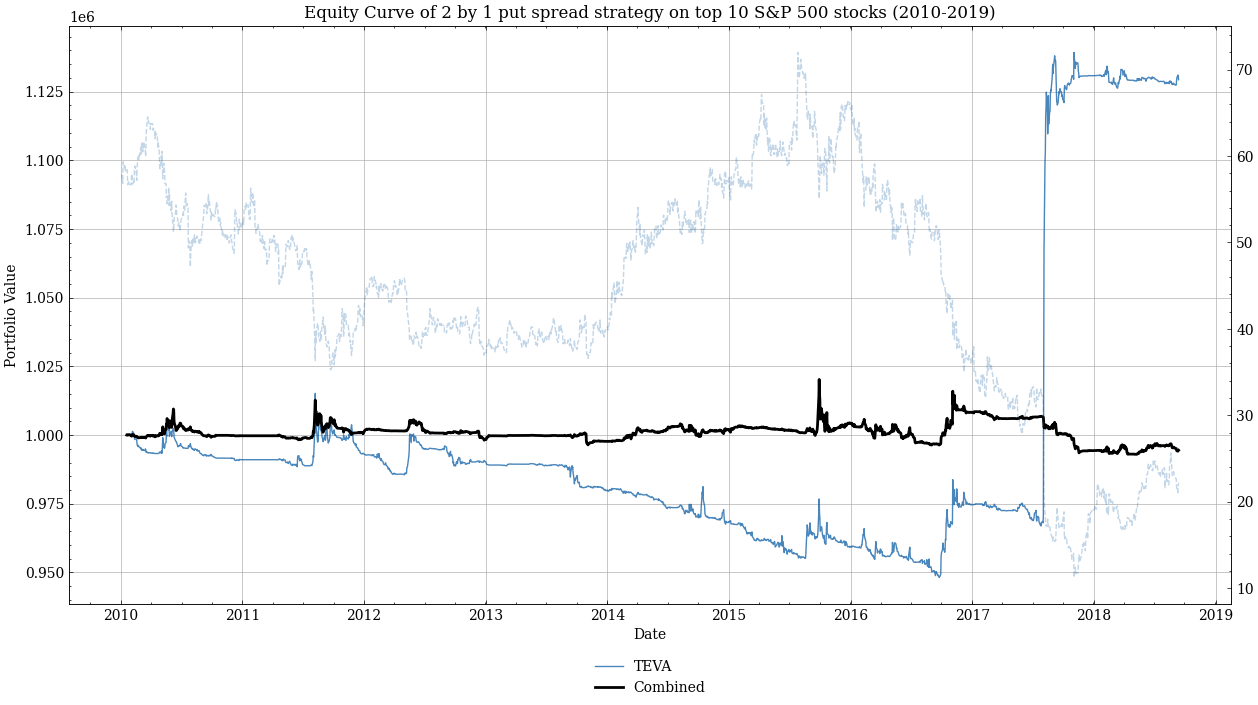

In [5]:
start = "2010-01-01"
end   = "2019-01-01"

import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("default")
plt.style.use('science')

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

equity_combined = data_manager.combined_outputs['multi_stock']['equity']

equity_combined.index = pd.to_datetime(equity_combined.index)
equity_combined = equity_combined.loc[start_dt:end_dt]

fig, ax1  = plt.subplots(figsize=(15, 7.5))
ax2 = ax1.twinx()


for tick in universe.ticks:
    equity_tick = data_manager.outputs[tick]['equity']
    stock_prices = data_manager.data[tick]['underlying_close']
    equity_tick.index = pd.to_datetime(equity_tick.index)
    equity_tick = equity_tick.loc[start_dt:end_dt]
    ax1.plot(equity_tick, label=f"{tick}", alpha=0.75)
    price_series = stock_prices.groupby(level='trade_date_idx').first()
    price_series.index = pd.to_datetime(price_series.index).tz_localize(None)
    ax2.plot(price_series.loc[start_dt:end_dt], label=f"{tick} Price", linestyle='--', alpha=0.25)

ax1.plot(equity_combined, label="Combined", color='black', linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Portfolio Value")
ax1.grid(True)
handles, labels = ax1.get_legend_handles_labels()
ncols = int(np.ceil(len(labels) / 4))
ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.075), ncol=ncols, frameon=False)
plt.title("Equity Curve of 2 by 1 put spread strategy on top 10 S&P 500 stocks (2010-2019)")
plt.show()